In [1]:
#!pip install ipywidgets
import torch
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import re
import emoji
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import gensim
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk import tokenize as tokenize_nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from string import punctuation
from keras.preprocessing.sequence import pad_sequences

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-11 01:40:02.840434: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 01:40:02.866042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 01:40:04.712343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /u/18/penttih5/unix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Adapted from https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
def hashtag(text):
  FLAGS = re.MULTILINE | re.DOTALL
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " 

def clean_data(text):
  FLAGS = re.MULTILINE | re.DOTALL
  eyes = r"[8:=;]"
  nose = r"['`\-]?"
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)

  text = emoji.demojize(text)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\w+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
  text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
  text = re_sub(r"  ", r" ")
  text = re_sub(r" ([A-Z]){2,} ", allcaps)
  text = word_tokenize(text.lower())
  text = [token for token in text if token not in punctuation and token not in STOPWORDS]
  return text

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['text']:
    temp_list.append(clean_data(t))
  tweet_df['clean_text'] = temp_list
  return tweet_df

In [5]:
df = pd.read_csv("data/train_2024.csv", quoting=3)
test_df = pd.read_csv("data/dev_2024.csv", quoting=3)
df.head()

,id,text,label
0,0,Except that Desmond played first base last nig...,0
1,1,What i find funny is the loyalty and blindness...,0
2,2,Read the article not just the headline & you ...,0
3,3,Speaking of a horses backside is that where y...,1
4,4,Michael Barone- gee are you dumb. No other wo...,1


In [6]:
train_df = preprocessing_tweet(df)
test_df = preprocessing_tweet(test_df)
train_df.head()

,id,text,label,clean_text
0,0,Except that Desmond played first base last nig...,0,"[desmond, played, base, night, tapia, lf, allc..."
1,1,What i find funny is the loyalty and blindness...,0,"[funny, loyalty, blindness, english, community..."
2,2,Read the article not just the headline & you ...,0,"[read, article, headline]"
3,3,Speaking of a horses backside is that where y...,1,"[speaking, horses, backside, head]"
4,4,Michael Barone- gee are you dumb. No other wo...,1,"[michael, barone-, gee, dumb, words, needed]"


In [7]:
def split_data(cleantweet):
  trainX, valX = train_test_split(cleantweet, test_size=0.2, random_state=42)
  return trainX, valX

#extract tweet and y
def extract_tweet_and_y(raw_data_df):
  tweet, target = raw_data_df['clean_text'].tolist(), raw_data_df['label'].tolist()
  return tweet, target

In [8]:
train_df, val_df = split_data(df)
X_train, y_train = extract_tweet_and_y(train_df)
X_val, y_val = extract_tweet_and_y(val_df)
X_test, y_test = extract_tweet_and_y(test_df)

In [9]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

79200
19800
11000


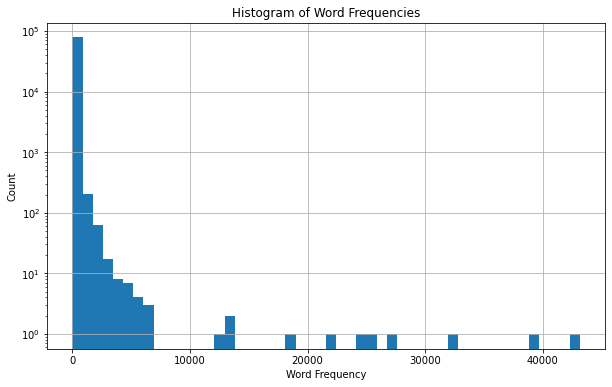

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

vocab = {}
word_freq = Counter()

# Count word frequencies and build vocab
for tweet in df["clean_text"]:
    for word in tweet:
        word_freq[word] += 1

# Assign indices to words based on frequency
vocab_index = 1
for word, freq in word_freq.items():
    vocab[word] = vocab_index
    vocab_index += 1

# Add 'UNK' for unknown words
vocab['UNK'] = len(vocab) + 1

# Plot histogram of word frequencies
plt.figure(figsize=(10, 6))
plt.hist(word_freq.values(), bins=50, log=True)
plt.title("Histogram of Word Frequencies")
plt.xlabel("Word Frequency")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [11]:
vocab = {}
reverse_vocab = {}
vocab_index = 1
for tweet in df["clean_text"]:
    for word in tweet:
        if word not in vocab:
            vocab[word] = vocab_index
            reverse_vocab[vocab_index] = word
            vocab_index += 1
vocab['UNK'] = len(vocab) + 1
reverse_vocab[len(vocab)] = 'UNK'
print(dict(list(vocab.items())[0:5]), "\n Length of vocab =", len(vocab))

{'desmond': 1, 'played': 2, 'base': 3, 'night': 4, 'tapia': 5} 
 Length of vocab = 78559


In [12]:
def gen_seq(df):
    x = []
    for tweet in df["clean_text"]:
        seq = []
        for word in tweet:
            seq.append(vocab.get(word, vocab['UNK']))
        x.append(seq)
    df["seq"] = x

gen_seq(train_df)
gen_seq(val_df)
gen_seq(test_df)

In [13]:
max_seq_length = train_df['seq'].apply(len).max()
print(max_seq_length)
pad_length = 64

train_df['seq_padded'] = train_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
val_df['seq_padded'] = val_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
test_df['seq_padded'] = test_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]

308


In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx]['seq_padded']
        label = self.dataframe.iloc[idx]['label']
        return torch.tensor(sequence), torch.tensor(label)
    

trainset = CustomDataset(train_df)
valset = CustomDataset(val_df)
testset = CustomDataset(test_df)

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


In [15]:
import torch.nn.functional as F
n_filters = 1000
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
class CNNModel(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab)+1, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[0],embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[1],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[2],embedding_dim))
        self.fc = nn.Linear(len(FILTER_SIZES)*n_filters, OUTPUT_DIM )
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        embedded = self.embedding(x)
                
        
        embedded = embedded.unsqueeze(1)
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return torch.sigmoid(self.fc(cat))
    

In [16]:
def compute_loss_and_accuracy(model, loader, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.float().to(device)
            outputs = model.forward(x)
            loss = criterion(outputs, y)
            losses.append(loss.cpu().numpy())
            predicted = torch.round(outputs)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return np.mean(losses), correct / total

def print_progress(epoch, train_loss, train_accuracy, val_loss, val_accuracy):
    print('Epoch {}: Train loss: {:.4f}, Train accuracy: {:.4f}, Val loss: {:.4f}, Val accuracy {:.4f}'.format(
        epoch, train_loss, train_accuracy, val_loss, val_accuracy))
    
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [17]:
#embedding_dim = max_seq_length
embedding_dim = pad_length
model = CNNModel(embedding_dim)
model.to(device)

CNNModel(
  (embedding): Embedding(78560, 64)
  (conv_0): Conv2d(1, 1000, kernel_size=(3, 64), stride=(1, 1))
  (conv_1): Conv2d(1, 1000, kernel_size=(4, 64), stride=(1, 1))
  (conv_2): Conv2d(1, 1000, kernel_size=(5, 64), stride=(1, 1))
  (fc): Linear(in_features=3000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

5801841

In [19]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

In [20]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.BCELoss()
n_epochs = 15
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
early_stop = EarlyStopping(tolerance=0.01, patience=1)

for epoch in range(n_epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    for data in trainloader:
        x_train, y_train = data
        x_train, y_train = x_train.to(device), y_train.float().to(device)
        optimizer.zero_grad()
        outputs = model.forward(x_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(outputs, y_train)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()
    for x_val, y_val in valloader:

        x_val, y_val = x_val.to(device), y_val.to(device)

        outputs = model(x_val)
        val_loss = criterion(outputs.squeeze(), y_val.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(outputs,y_val)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(trainloader.dataset)
    epoch_val_acc = val_acc/len(valloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    if early_stop.stop_criterion(epoch_vl_loss):
        print("Stop after %d epochs" % (epoch + 1))
        break

Epoch 1
train_loss : 0.5413103083416411 val_loss : 0.4458570726456181
train_accuracy : 73.19696969696969 val_accuracy : 79.81818181818183
Epoch 2
train_loss : 0.3995575798925175 val_loss : 0.36055298332245117
train_accuracy : 82.93055555555556 val_accuracy : 84.82828282828282
Epoch 3
train_loss : 0.3078057576025052 val_loss : 0.2791052989421352
train_accuracy : 88.29166666666667 val_accuracy : 89.41919191919192
Epoch 4
train_loss : 0.26132260778127464 val_loss : 0.251517957929642
train_accuracy : 90.46212121212122 val_accuracy : 91.01010101010101
Epoch 5
train_loss : 0.23705353221956862 val_loss : 0.22995220326608226
train_accuracy : 91.36111111111111 val_accuracy : 91.5959595959596
Epoch 6
train_loss : 0.21913147162832622 val_loss : 0.21905654865887858
train_accuracy : 91.9419191919192 val_accuracy : 91.9040404040404
Epoch 7
train_loss : 0.2083551273086922 val_loss : 0.21451665432222428
train_accuracy : 92.3459595959596 val_accuracy : 91.91414141414141
Epoch 8
train_loss : 0.200716704

In [21]:
def save_model(model, filename, confirm=True):
    if confirm:
        try:
            save = input('Do you want to save the model (type yes to confirm)? ').lower()
            if save != 'yes':
                print('Model not saved.')
                return
        except:
            raise Exception('Failed')

    torch.save(model.state_dict(), filename)
    print('Model saved to %s.' % (filename))

save_model(model, 'model/cnn.pth', confirm=True)

Model saved to cnn.pth.


In [22]:
model.eval()
batch_size=1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

train_pred = []
val_pred = []
test_pred = []

for data in trainloader:
    x_train, _ = data
    x_train = x_train.to(device)
    y_pred = model.forward(x_train)[0][0]
    train_pred.append(y_pred.cpu().data.numpy().item())

for data in valloader:
    x_val, _ = data
    x_val = x_val.to(device)
    y_pred = model.forward(x_val)[0][0]
    val_pred.append(y_pred.cpu().data.numpy().item())

for data in testloader:
    x_test, _ = data
    x_test = x_test.to(device)
    y_pred = model.forward(x_test)[0][0]
    test_pred.append(y_pred.cpu().data.numpy().item())

In [23]:
train_pred = [np.round(y) for y in train_pred]
val_pred = [np.round(y) for y in val_pred]
test_pred = [np.round(y) for y in test_pred]

In [24]:
y_train = list(train_df["label"])
y_val = list(val_df["label"])
y_test = list(test_df["label"])

Train accuracy: 0.9570959595959596
Train precision: 0.9469816633472976
Train recall: 0.9370073389508018
Train F1 score: 0.9419680978242306


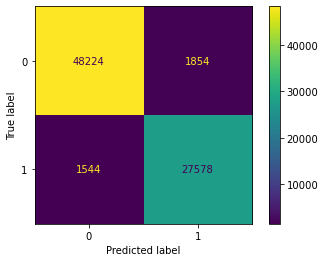

In [25]:
print("Train accuracy:", accuracy_score(train_pred, y_train))
print("Train precision:", precision_score(train_pred, y_train))
print("Train recall:", recall_score(train_pred, y_train))
print("Train F1 score:", f1_score(train_pred, y_train))
conf_mat = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Val accuracy: 0.9244949494949495
Val precision: 0.8913733609385783
Val recall: 0.901200111638292
Val F1 score: 0.8962598015404899


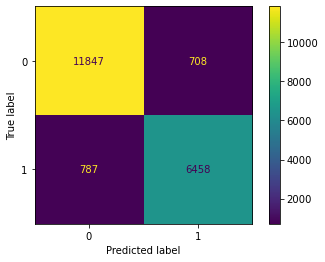

In [26]:
print("Val accuracy:", accuracy_score(val_pred, y_val))
print("Val precision:", precision_score(val_pred, y_val))
print("Val recall:", recall_score(val_pred, y_val))
print("Val F1 score:", f1_score(val_pred, y_val))
conf_mat = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.9240909090909091
Test precision: 0.8982667671439337
Test recall: 0.8926610084872691
Test F1 score: 0.8954551145611619


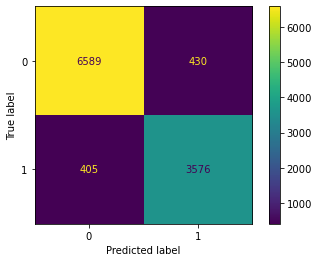

In [27]:
print("Test accuracy:", accuracy_score(test_pred, y_test))
print("Test precision:", precision_score(test_pred, y_test))
print("Test recall:", recall_score(test_pred, y_test))
print("Test F1 score:", f1_score(test_pred, y_test))
conf_mat = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()